In [1]:
%reset -f
import cv2
import os
import glob 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import datetime
sys.path.insert(1, r'C:\Users\hjoon\Documents\PycharmProjects\CameraCalibration')

from ipynb_modules.analyzer import *

def now_str():
    now = datetime.datetime.now()
    output = '*[{}/{} {}:{}:{}]*'.format(now.month, now.day, now.hour, now.minute, now.second)
    return output


from modules.calibrator import *
from configs import *

mpl.style.use('seaborn')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
cams = Calibrator.cams

%matplotlib notebook
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print('init')


init


## Load triangulation output

In [2]:
# load triangulation data
print('start')
configs = {
}
trian_path = r'D:\CalibrationData\CameraCalibration\2020_01_01_KateyCapture\Triangulation\output\triangulation_output.txt'
cam_params, frames, img_pts_path = Analyzer.load_triangulation_output(trian_path, configs)
for cam_idx, p in cam_params.items():
    k = [p['k1'], p['k2'], p['k3'], p['k4'], p['k5'], p['k6']]
    p = [p['p1'], p['p2'], p['p3'], p['p4'], p['p5'], p['p6']]
    print('cam[{}]\n  k={}\n  p={}'.format(cam_idx, k, p))
print('done')

start
cam[0]
  k=[0.1099, 0.109572, 0.0521825, 0.174898, 0.0167182, 0.141946]
  p=[-0.000102586, 0.00091288, 0.0, 0.0, 0.0, 0.0]
cam[1]
  k=[0.099169, 0.100046, 0.0765434, 0.160688, 0.0245067, 0.14944]
  p=[0.000113559, 8.47418e-05, 0.0, 0.0, 0.0, 0.0]
cam[2]
  k=[0.0797521, 0.0979421, 0.015405, 0.144842, -4.86836e-05, 0.118907]
  p=[-0.000311344, -0.000136771, 0.0, 0.0, 0.0, 0.0]
cam[3]
  k=[0.0701346, 0.1055, -0.0110081, 0.14003, -0.0138747, 0.118454]
  p=[-0.000489735, 6.55771e-05, 0.0, 0.0, 0.0, 0.0]
cam[4]
  k=[-0.00621585, 0.108248, -0.127197, 0.0758064, -0.0945759, 0.13748]
  p=[0.000234633, 0.000102852, 0.0, 0.0, 0.0, 0.0]
cam[5]
  k=[0.0479929, 0.112093, -0.0713203, 0.125383, -0.0529848, 0.1262]
  p=[-0.000650895, -2.71329e-05, 0.0, 0.0, 0.0, 0.0]
cam[6]
  k=[-0.0166756, 0.110853, -0.136087, 0.0689613, -0.103879, 0.140707]
  p=[-0.00039606, 6.46489e-05, 0.0, 0.0, 0.0, 0.0]
cam[7]
  k=[0.0500642, 0.103203, -0.0379897, 0.12554, -0.0326818, 0.115989]
  p=[-0.00055137, -0.00074741

## Reproject

In [3]:
configs = {
    'max_k': 6,
    'max_p': 2,
    'radial_model': 1,
    'loss_type':'none',
    'loss_huber_delta': 1.0
}
img_pts_pred = Analyzer.reproject_triangulation_output(cam_params, frames, configs)
print()
print(len(img_pts_pred.keys()), 'frames loaded.')

  0/604  100/604  200/604  300/604  400/604  500/604  600/604
604 frames loaded.


## Load input image points

In [4]:
img_pts_opencv = Analyzer.load_triangulation_inputs(img_pts_path)
print(img_pts_path)
print(len(img_pts_opencv.keys()), 'frames loaded.')

D:\CalibrationData\CameraCalibration\2020_01_01_KateyCapture/BundleAdjustment/input/image_points.json
604 frames loaded.


## Compute reprojection errors

In [5]:
reproj_errs, err_data, sanity_err = Analyzer.compute_triangulatoin_reproj_errs(img_pts_pred, img_pts_opencv, configs)

final_cost = 0
for frame in frames:
    final_cost += np.sum(frame['costs'])
mean = sum(reproj_errs)/len(reproj_errs)
max_err = max(reproj_errs)
var = np.var(reproj_errs)

num_frames = len(err_data)
print('{} frames'.format(num_frames))
print('- mean = {:<8.4f} [pixel/point]'.format(mean))
print('- var  = {:<8.4f}'.format(var))
print('- max  = {:<8.4f} [pixel/point]'.format(max_err))

# sanity check
# sanity_err = 0.5*np.sum(np.array(reproj_errs)**2)

reg = 0
if reg:
    for cam_idx, p in cam_params.items():
        # reg
        sanity_err += 0.5*(p['k1']**2 + p['k2']**2 + p['k3']**2 + p['k4']**2 + p['k5']**2 + p['k6']**2 + p['p1']**2 + p['p2']**2)

print()
print('Sanity check: mine({:.4f}) vs ceres({:.4f}) | error={:.2f}%'.format(sanity_err, final_cost, abs(final_cost-sanity_err)/final_cost * 100.0))
print('done')

604 frames
- mean = 0.0952   [pixel/point]
- var  = 0.0043  
- max  = 3.2851   [pixel/point]

Sanity check: mine(2384.0562) vs ceres(2383.4898) | error=0.02%
done


## Reprojection error histogram

|idx |max. errs ||   max    | num cams ||  0  |  1  |  2  |  3  |  4  |  5  |  6  |  7  |  8  |  9  | 10  | 11  | 12  | 13  | 14  | 15  |
| 1  |00375.pgm ||   1.28   |    15    ||0.25 |0.28 |0.19 |0.30 |0.18 |     |0.16 |0.25 |0.24 |0.31 |0.22 |1.28 |0.16 |0.20 |0.14 |0.19 |
| 2  |00695.pgm ||   1.31   |    4     ||     |     |     |     |1.31 |1.16 |0.30 |0.40 |     |     |     |     |     |     |     |     |
| 3  |00700.pgm ||   1.44   |    4     ||     |     |     |     |1.44 |1.07 |0.22 |0.47 |     |     |     |     |     |     |     |     |
| 4  |01245.pgm ||   2.02   |    6     ||     |     |     |     |     |     |1.72 |1.94 |1.68 |2.02 |0.87 |0.39 |     |     |     |     |
| 5  |01250.pgm ||   1.99   |    5     ||     |     |     |     |     |     |1.00 |0.73 |1.94 |1.99 |0.89 |     |     |     |     |     |
| 6  |01345.pgm ||   3.29   |    5     ||     |     |     |     |     |     |     |     |2.05 |3.29 |1.16 |2.67 |1.67 |     |     |     |
| 7  |01350.pgm ||   1.26   |    4

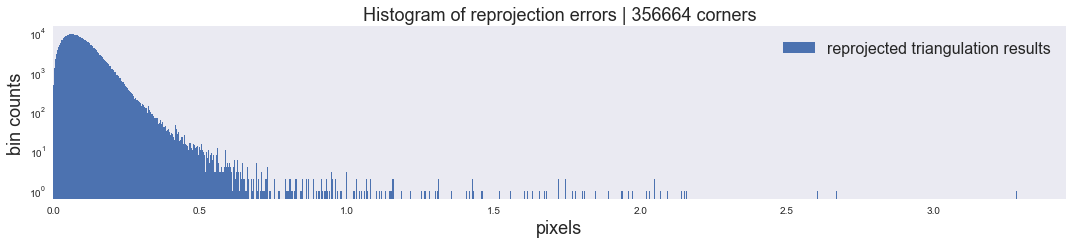

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from matplotlib.gridspec import GridSpec
%matplotlib inline
do_print = True
max_err_image_names = []
if do_print:
    print('|{:^4}|{:^10}||{:^10}|{:^10}||{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|'.format('idx', 'max. errs', 'max', 'num cams', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))
    idx = 1
    for img_name, v in err_data.items():
        errs = {}
        max_err = -1
        num_cams = 0
        for cam_idx in range(16):
            if cam_idx in v:
                errs[cam_idx] = '{:.2f}'.format(np.max(v[cam_idx]))
                max_err = max(np.max(v[cam_idx]), max_err)
                num_cams += 1
            else:
                errs[cam_idx] = ''
        if max_err > 1:
            print('|{:^4}|{:^10}||{:^10.2f}|{:^10.0f}||{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|{:^5}|'.format(idx, img_name+'.pgm', max_err, num_cams, errs[0], errs[1], errs[2], errs[3], errs[4], errs[5], errs[6], errs[7], errs[8], errs[9], errs[10], errs[11], errs[12], errs[13], errs[14], errs[15]))
            max_err_image_names.append(img_name)
            idx += 1
print(max_err_image_names)
mpl.style.use('seaborn')
# mpl.rcParams['axes.prop_cycle'] = cycler(color='rbgcmyk')
num_bins = 1000
plt.rcParams["figure.figsize"] = (15, 3.5) # (w, h)
fig = plt.figure(tight_layout=True)
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[0, :])

# linear
ax1.hist(reproj_errs, bins=num_bins)
ax1.set_yscale('log')
ax1.set_xlim(left=0)
ax1.set_xlabel('pixels', fontsize=18)
ax1.set_ylabel('bin counts', fontsize=18)
ax1.set_title('Histogram of reprojection errors | {} corners'.format(len(reproj_errs)), fontsize=18)
ax1.legend(['reprojected triangulation results'], fontsize=16)
plt.grid(False)
plt.show()

In [8]:
print('start')
mpl.style.use('default')
import mpld3
mpld3.enable_notebook()

img_names = ['00200']

# img_names = ['00985']
for img_name in img_names:
    img_path = r'\\DATACHEWER\shareZ\2019_12_13_Lada_Capture\Converted\\'
    scale = 1.0
    Analyzer.render_projections(img_name, scale, img_pts_pred[img_name], img_pts_opencv[img_name], err_data[img_name], img_path)

        
# configure plots
plt.rcParams["figure.figsize"] = (13, 20) # (w, h)
plt.show()
print('done')


start


KeyboardInterrupt: 

## [SAVE] render image

In [7]:
mpl.style.use('default')
import mpld3
mpld3.enable_notebook()
%matplotlib inline
folder_name = '2019_12_24_Marianne_Capture'
save_path = r'D:\CalibrationData\CameraCalibration\\' + folder_name + '\\ExportedImages'
if not os.path.exists(save_path):
    os.mkdir(save_path)
save_path += '\\Reprojections'
if not os.path.exists(save_path):
    os.mkdir(save_path)
print('Saving to:', save_path)
# img_names = ['00580', '00610', '00635', '00835', '00860', '00920', '00985', '02090', '02105', '02810', '04420', '04425', '04475', '04505', '04510', '04520', '04525', '04530', '04540', '04550', '04560']
img_names = ['01970', '02115', '02275', '02350', '02435', '02535', '02545', '02550', '02625', '02680', '02755', '03250', '03830', '03895', '03900']
print('start')
save = 1
# img_names = ['00985']
for img_name in img_names:
    print(img_name)
    img_path = r'\\DATACHEWER\shareZ\\' + folder_name + '\\Converted\\'
    scale = 1.0
    Analyzer.render_projections(img_name, scale, img_pts_pred[img_name], img_pts_opencv[img_name], err_data[img_name], img_path)
    # configure plots
    plt.rcParams["figure.figsize"] = (13, 20) # (w, h)
    
    if save:
        plt.savefig(save_path + '\\tri_' + img_name + '.jpg', dpi=300)
        plt.close('all')
        
    if not save:    
        plt.show()
print('done')


Saving to: D:\CalibrationData\CameraCalibration\\2019_12_24_Marianne_Capture\ExportedImages\Reprojections
start
01970
02115
02275
02350
02435
02535
02545
02550
02625
02680
02755
03250
03830
03895
03900
done


## [3D] Render

In [43]:
def render_camera(ax, cam_idx, R_se3, t_se3):
    ax.scatter(t_se3[0], t_se3[1], t_se3[2])

def render_axis(ax, L):
    ax.plot([0, L], [0, 0], [0, 0], 'r')
    ax.plot([0, 0], [0, L], [0, 0], 'g')
    ax.plot([0, 0], [0, 0], [0, L], 'b')

<IPython.core.display.Javascript object>


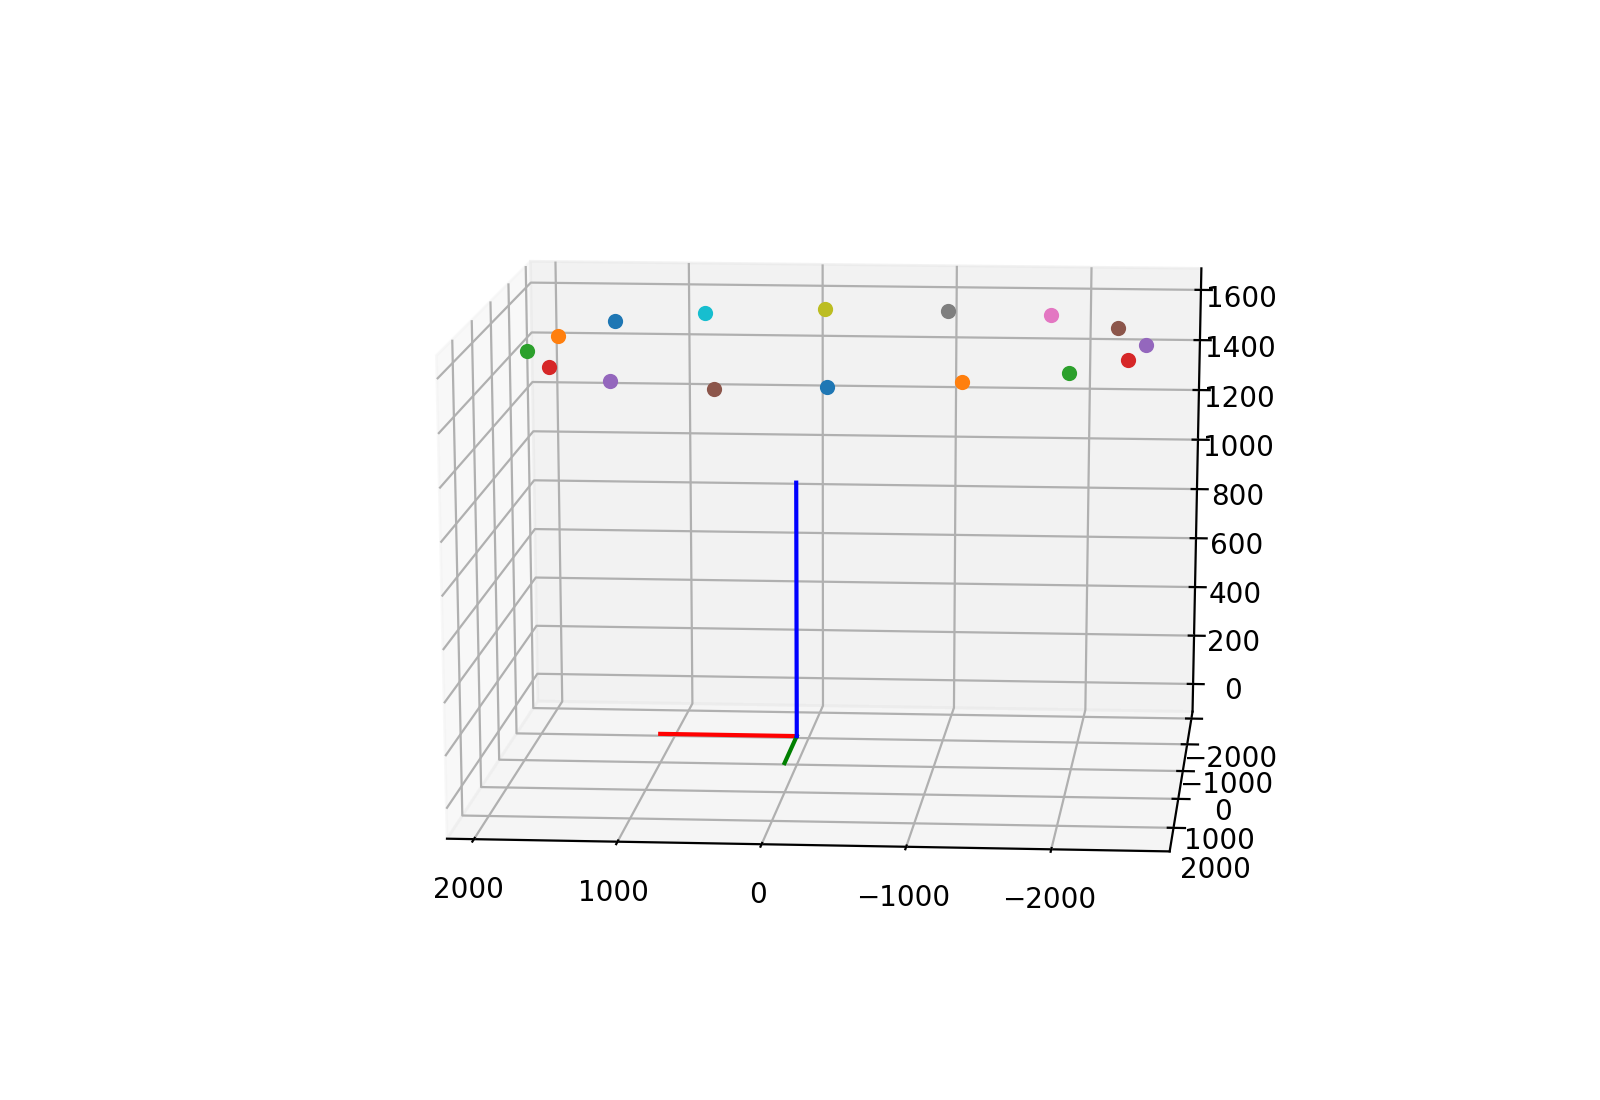

Camera 0: (-428.34, 2462.46, 1561.66)
Camera 1: (-1329.66, 2239.33, 1570.78)
Camera 2: (-2025.29, 1626.86, 1561.71)
Camera 3: (-2405.03, 936.69, 1558.01)
Camera 4: (-2495.15, 81.84, 1551.33)
Camera 5: (-2258.76, -900.58, 1544.08)
Camera 6: (-1743.29, -1517.95, 1549.44)
Camera 7: (-960.67, -1953.17, 1529.82)
Camera 8: (-42.33, -1958.10, 1531.50)
Camera 9: (822.56, -1733.88, 1524.83)
Camera 10: (1428.96, -1143.43, 1530.84)
Camera 11: (1757.21, -389.20, 1527.02)
Camera 12: (1869.53, 484.01, 1532.66)
Camera 13: (1614.63, 1290.30, 1532.89)
Camera 14: (1097.38, 2045.05, 1544.59)
Camera 15: (345.64, 2429.19, 1547.43)


In [44]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
render_axis(ax, 1000)
cam_sensor_shape = (22, 11.88)  # mm
image_shape = (2160, 4000)
for cam_idx, p in cam_params.items():
    rvec = p['ax']
    tvec = p['t']
    fx = p['fx']
    fy = p['fy']
    focal_length = (fx * cam_sensor_shape[1] / image_shape[1] + fy * cam_sensor_shape[0] / image_shape[0]) / 2.
    
    R, _ = cv2.Rodrigues(rvec)
    R_se3 = R.T
    t_se3 = -R.T.dot(tvec)
    print('Camera {}: ({:.2f}, {:.2f}, {:.2f})'.format(cam_idx, t_se3[0], t_se3[1], t_se3[2]))
    render_camera(ax, cam_idx, R_se3, t_se3)
